# Basis comparison
Compare reconstruction performance of different choices of basis:
* Raw input
* POD modes
* Random projections

We'll perform comparisons using Olivetti faces dataset from AT&T.

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

import pysensors as ps

## Setup

Data consists of 10 pictures of 40 different people, each 64 x 64.

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

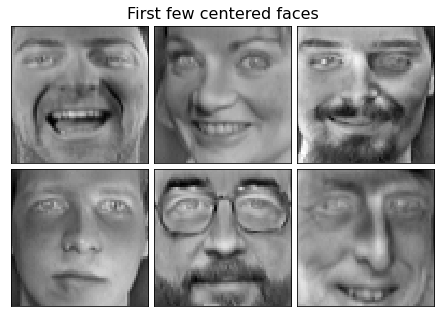

In [5]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [6]:
X_train, X_test = X[:300], X[300:]

## Reconstruction error

### Varying the number of basis modes
First we'll fix the number of sensors at 100 and see how the number of basis modes used affects the reconstruction error.

In [7]:
max_basis_modes = 200
n_sensors = 100

models = [
    (
        'Identity',
        ps.SensorSelector(
            n_sensors=n_sensors, 
            basis=ps.basis.Identity(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'POD',
        ps.SensorSelector(
            n_sensors=n_sensors, 
            basis=ps.basis.POD(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'Random Projection',
        ps.SensorSelector(
            n_sensors=n_sensors, 
            basis=ps.basis.RandomProjection(n_basis_modes=max_basis_modes)
        )
    ),
]

/home2/bdesilva/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/basis/_identity.py:68: UserWarning: Only the first 200 examples were retained.
  warn(f"Only the first {self.n_basis_modes} examples were retained.")


Train time for Identity basis: 0.0048236846923828125
Train time for POD basis: 4.804528713226318
Train time for Random Projection basis: 0.07799649238586426


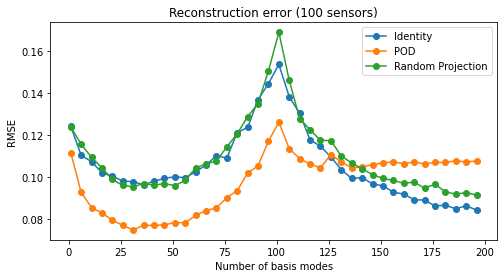

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of basis modes",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_sensors} sensors)",
)

n_basis_modes_range = np.arange(1, 200, 5)
for name, model in models:
    t0 = -time()
    model.basis.fit(X_train)
    print(f"Train time for {name} basis: {time() + t0}")
    
    errors = np.zeros_like(n_basis_modes_range, dtype=np.float64)
    for k, n in enumerate(n_basis_modes_range):
        model.update_n_basis_modes(n, X_test)
        errors[k] = model.reconstruction_error(X_test, [n_sensors])[0]
    
    ax.plot(n_basis_modes_range, errors, "-o", label=name)

ax.legend()
plt.show()

The Random projection and Identity bases give similar performance, with Identity winning out for larger numbers of modes. The POD basis performs best for smaller numbers of modes, but its accuracy tapers off as the number of basis modes grows large.

### Varying the number of sensors
Next we'll explore the reconstruction error for a fixed number of basis modes (100) as the number of **sensors** is varied.

In [9]:
n_basis_modes = 100

models = [
    (
        'Identity',
        ps.SensorSelector(basis=ps.basis.Identity(n_basis_modes=n_basis_modes))
    ),
    (
        'POD',
        ps.SensorSelector(basis=ps.basis.POD(n_basis_modes=n_basis_modes))
    ),
    (
        'Random Projection',
        ps.SensorSelector(basis=ps.basis.RandomProjection(n_basis_modes=n_basis_modes))
    ),
]

/home2/bdesilva/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/basis/_identity.py:68: UserWarning: Only the first 100 examples were retained.
  warn(f"Only the first {self.n_basis_modes} examples were retained.")


Train time for Identity basis: 0.47089242935180664
Train time for POD basis: 1.5349581241607666
Train time for Random Projection basis: 0.4870896339416504


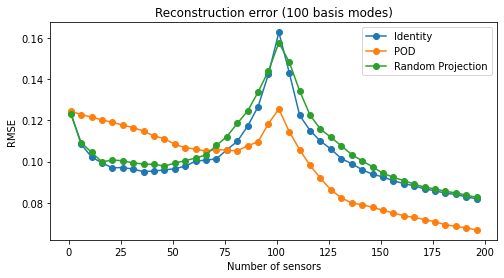

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of sensors",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_basis_modes} basis modes)",
)

sensor_range = np.arange(1, 200, 5)
for name, model in models:
    t0 = -time()
    model.fit(X_train)
    print(f"Train time for {name} basis: {time() + t0}")
    
    errors = model.reconstruction_error(X_test, sensor_range=sensor_range)
    ax.plot(sensor_range, errors, "-o", label=name)
    
ax.legend()
plt.show()

When the sensor count is small, Identity and Random projection bases produce the best reconstruction error. As the number of sensors grows, the POD basis wins out.

## Sensor locations
Let's compare the sensor locations for the three bases.

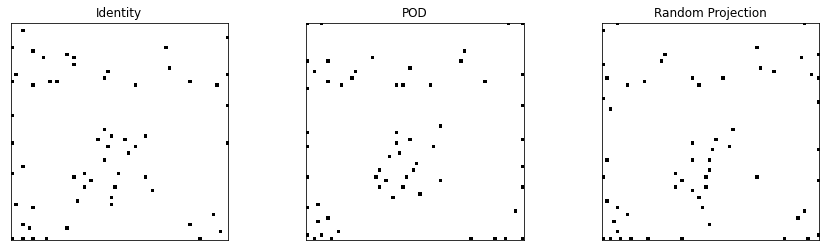

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
n_sensors = 60

for ax, (name, model) in zip(axs, models):
    img = np.zeros(n_features)
    sensors = model.get_all_sensors()[:n_sensors]
    img[sensors] = 16
    
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
    ax.set(title=name, xticks=[], yticks=[])

Similar sensor locations are chosen for this dataset across all three bases considered.